## This is a non-bayesian version of the timelag regressions

In [3]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
        trait_factor_names_short = ["TF3", "TF2", "TF1"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
        #trait_factor_names_short = ["TF3", "TF2", "TF1","TA"]
        trait_factor_names_short = ["TF3", "TF2", "TF1"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Probest',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'DangerState',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

#vars = ["Worry", "Probest", "SocialDist", 
# "AvoidBeh", "AvoidAnx", "InforSeek", 
# "DangerSate", "Deaths", "WorkHome"]


vars = ["AvoidBeh", "InforSeek", "Probest", 
        "DangerState", "Deaths","Cases"]


df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")

# Information seeking is skewed (exp) 
df["InforSeek"] = np.exp(df["InforSeek"]) 

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")

    
tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)

def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df



/data/drive/postdoc/Project4_covid


In [4]:
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()


### Gather data and 

In [5]:
win=2


for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    regdf = pd.DataFrame()
    for s in np.arange(win,20):

        #tdf.loc[:,(dv,[1,2])]
        x_dv = demultindex(tdf.loc[:,(dv,np.arange(s-win,s+1))])
        x_dv = x_dv.rename(columns=dict(zip(x_dv.columns, [dv+"_lag"+str(x) for x in np.arange(win,-1, -1)])))

        x_dv["session"] = "sess"+str(s+1)
        regdf = pd.concat([regdf, x_dv], axis=0)

    if dvidx == 0:
        fitdf = regdf
    else:
        fitdf = pd.merge(fitdf, regdf,  on=["PROLIFICID", "session"])

## Run regressions with only 2 variables

In [6]:
loadquick_v2 = True 
if loadquick_v2==False:
    fitdf2=fitdf.dropna().reset_index()
    pdf = pd.DataFrame()
    for dvidx, dv in enumerate(vars):
        for ividx, iv in enumerate(vars):
            if iv != dv:
                run_single_session = 0
                if run_single_session == 1: 
                    ddf = pd.DataFrame()
                    for s in np.arange(win,20):
                        ttf = fitdf2.loc[fitdf2["session"].isin(["sess"+str(s+1)]),:].drop(columns=["session", "PROLIFICID"]).dropna() 
                        ttf = ttf.loc[:,ttf.columns.str.contains(dv) | ttf.columns.str.contains(iv)]
                        eq = mm.generate_equation(dv+"_lag0",  list(ttf.columns[~ttf.columns.str.contains("_lag0")]), [""], "reducedrank") 
                        mod = smf.ols(eq, ttf)
                        res = mod.fit()
                        cdf = res.conf_int(alpha=0.05)
                        cdf.columns = ["CI5", "CI95"]
                        cdf["beta"] = res.params
                        cdf["dv"] = dv 
                        cdf["session"] = "sess"+str(s+1)

                        ddf = pd.concat([ddf, cdf])

                cols = list(fitdf2.columns[fitdf2.columns.str.contains(dv) | fitdf2.columns.str.contains(iv)]) 
                fitdf3 = fitdf2.loc[:,cols]
                eq = mm.generate_equation(dv+"_lag0",  list(fitdf3.columns[~fitdf3.columns.str.contains("_lag0")]), [""], "reducedrank") 
                #eq = mm.generate_equation(dv+"_lag0",  list(fitdf2.columns[~fitdf2.columns.isin([dv+"_lag0"])]), [""], "reducedrank") 
                md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
                res = md.fit()
                #print(res.summary())

                edf = res.conf_int(alpha=0.05)
                edf.columns = ["CI5", "CI95"]
                edf["beta"] = res.params
                edf["dv"] = dv 
                edf["iv"] = iv 
                edf["eq"] = eq

                pdf = pd.concat([pdf, edf])

    pdf = pdf.loc[~pdf.index.isin(["Intercept", "Group Var"]),:] 
    pdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_2vars_MLE_window"+str(win)+".csv")) 
else:
    pdf = pd.read_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_2vars_MLE_window"+str(win)+".csv")) 



In [7]:
pdf

Unnamed: 0       CI5      CI95      beta      dv           iv  \
0         Worry_lag2  0.162330  0.223696  0.193013   Worry     AvoidBeh   
1         Worry_lag1  0.278319  0.343072  0.310696   Worry     AvoidBeh   
2      AvoidBeh_lag2  0.008536  0.058732  0.033634   Worry     AvoidBeh   
3      AvoidBeh_lag1  0.015197  0.067329  0.041263   Worry     AvoidBeh   
4         Worry_lag2  0.171933  0.232659  0.202296   Worry    InforSeek   
..               ...       ...       ...       ...     ...          ...   
75       Deaths_lag1  0.784537  0.841031  0.812784  Deaths    InforSeek   
76  DangerState_lag2 -0.022558  0.032363  0.004902  Deaths  DangerState   
77  DangerState_lag1 -0.039393  0.015335 -0.012029  Deaths  DangerState   
78       Deaths_lag2 -0.160501 -0.105537 -0.133019  Deaths  DangerState   
79       Deaths_lag1  0.785687  0.842203  0.813945  Deaths  DangerState   

                                                   eq  
0   Worry_lag0 ~ Worry_lag2 + Worry_lag1 + AvoidBe...  
1   Worry_lag0 ~ Worry_lag2 + Worry_lag1 + AvoidBe...  
2   Worry_lag0 ~ Worry_lag2 + Worry_lag1 + AvoidBe...  
3   Worry_lag0 ~ Worry_lag2 + Worry_lag1 + AvoidBe...  
4   Worry_lag0 ~ Worry_lag2 + Worry_lag1 + InforSe...  
..                                                ...  
75  Deaths_lag0 ~ InforSeek_lag2 + InforSeek_lag1 ...  
76  Deaths_lag0 ~ DangerState_lag2 + DangerState_l...  
77  Deaths_lag0 ~ DangerState_lag2 + DangerState_l...  
78  Deaths_lag0 ~ DangerState_lag2 + DangerState_l...  
79  Deaths_lag0 ~ DangerState_lag2 + DangerState_l...  

[80 rows x 7 columns]

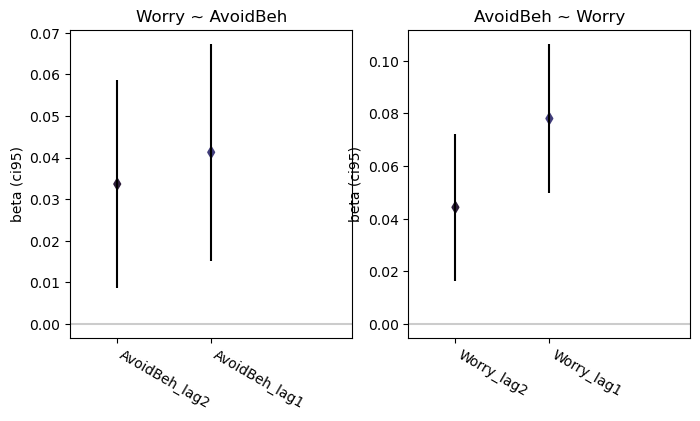

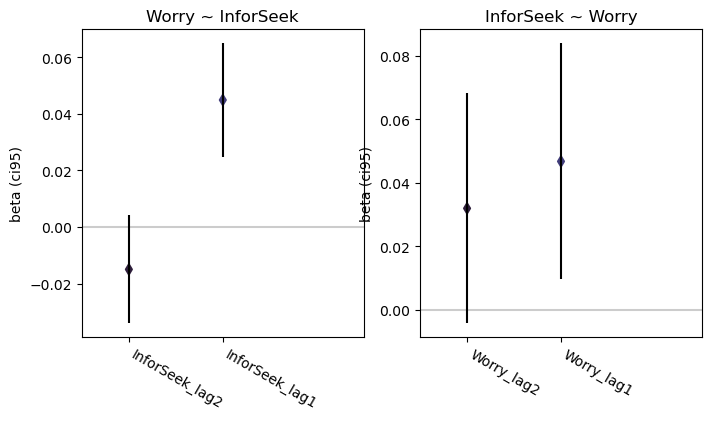

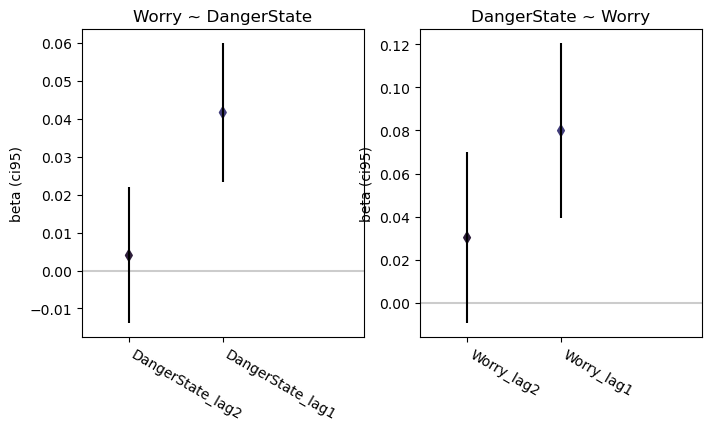

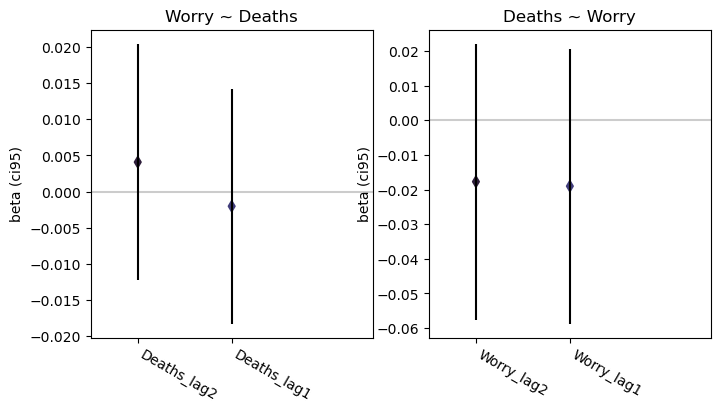

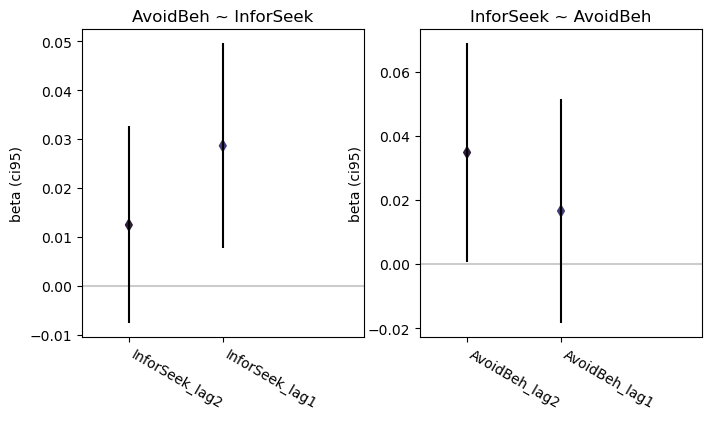

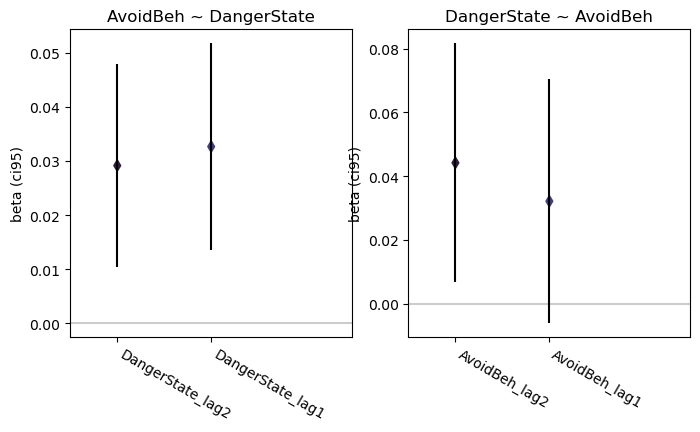

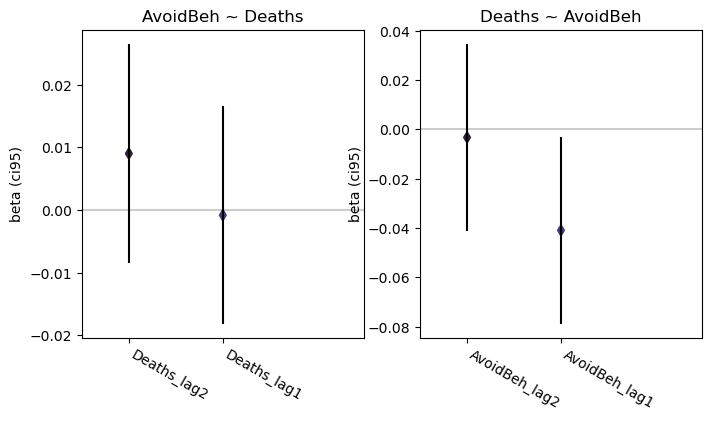

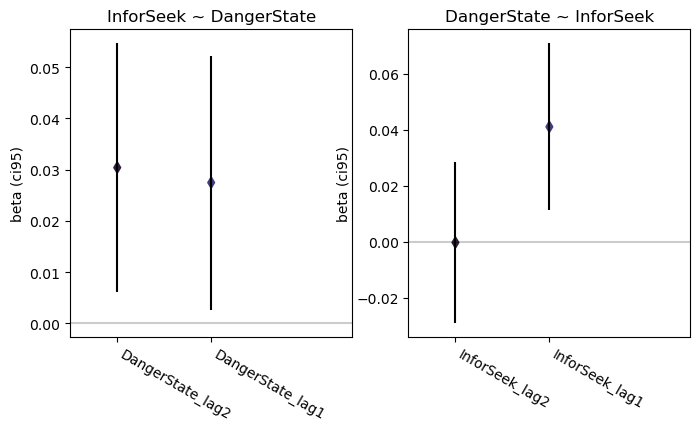

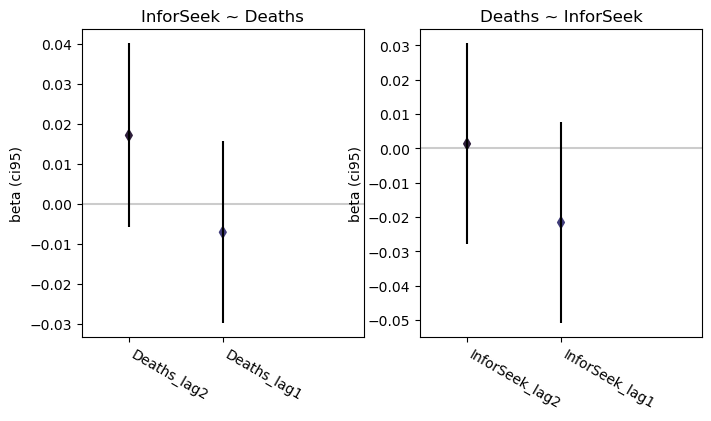

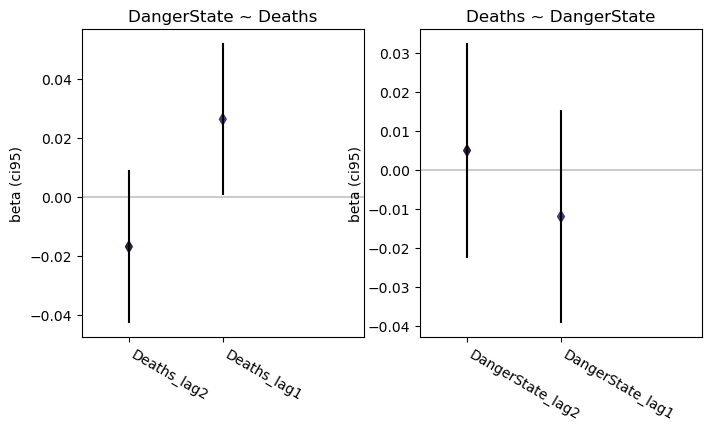

In [5]:
pdf["iv_name"] = pdf.index
combs = pd.DataFrame(list(combinations(vars,2)), columns=["v1", "v2"])
for v1, v2 in zip(combs.v1, combs.v2):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        df1 = pdf.loc[(pdf["dv"]==v1) & (pdf["iv"]==v2) & (pdf["iv_name"].str.contains(v2)),:]
        axs[0] = sns.pointplot(x="iv_name", y= "beta",
                        data=df1, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                        markers="d", scale=.75, ci=None, ax=axs[0])
        axs[0].vlines(np.arange(0,df1.shape[0],1), df1["CI5"], df1["CI95"], colors='black')
        axs[0].axhline(0, alpha=0.2, color='black')
        axs[0].set_title(v1+" ~ "+v2)
        axs[0].set_ylabel("beta (ci95)")
        axs[0].set_xlabel("")
        axs[0].set_xlim([-0.5, 2.5])
        axs[0].set_xticklabels(df1["iv_name"], rotation = -30, ha='left')

        df1 = pdf.loc[(pdf["dv"]==v2) & (pdf["iv"]==v1) & (pdf["iv_name"].str.contains(v1)),:]
        axs[1] = sns.pointplot(x="iv_name", y= "beta",
                        data=df1, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                        markers="d", scale=.75, ci=None, ax=axs[1])
        axs[1].vlines(np.arange(0,df1.shape[0],1), df1["CI5"], df1["CI95"], colors='black')
        axs[1].axhline(0, alpha=0.2, color='black')
        axs[1].set_title(v2+" ~ "+v1)
        axs[1].set_ylabel("beta (ci95)")
        axs[1].set_xlabel("")
        axs[1].set_xlim([-0.5, 2.5])
        axs[1].set_xticklabels(df1["iv_name"], rotation = -30, ha='left')


In [6]:
loadquick_v2 = False 
if loadquick_v2==False:
    fitdf2=fitdf.dropna()
    fitdf2 = fitdf2.join(df_id).reset_index() 
    pdf = pd.DataFrame()
    for dvidx, dv in enumerate(vars):
        for ividx, iv in enumerate(vars):
            if iv != dv:
                run_single_session = 0
                if run_single_session == 1: 
                    ddf = pd.DataFrame()
                    for s in np.arange(win,20):
                        ttf = fitdf2.loc[fitdf2["session"].isin(["sess"+str(s+1)]),:].drop(columns=["session"]).dropna().set_index("PROLIFICID")
                        ttf = ttf.join(df_id) 
                        # keep only relevant vars
                        ttf = ttf.loc[:,ttf.columns.str.contains(dv) | ttf.columns.str.contains(iv) | ttf.columns.isin(trait_factor_names_short)]
                        # get DVs 
                        dvs = ttf.columns[(ttf.columns.str.contains(dv) | ttf.columns.str.contains(iv)) & ~ttf.columns.str.contains("_lag0")]
                        
                        dvs_tt = [x+"*TF1" for x in dvs] + [x+"*TF2" for x in dvs]
                        eq = mm.generate_equation(dv+"_lag0",  dvs_tt, [""], "reducedrank") 
                        mod = smf.ols(eq, ttf)

                        cdf = res.conf_int(alpha=0.05)
                        cdf.columns = ["CI5", "CI95"]
                        cdf["beta"] = res.params
                        cdf["dv"] = dv 
                        cdf["session"] = "sess"+str(s+1)

                        ddf = pd.concat([ddf, cdf])

                eef = pd.DataFrame()
                ivs = list(fitdf2.columns[(fitdf2.columns.str.contains(dv) | fitdf2.columns.str.contains(iv)) & ~fitdf2.columns.str.contains("_lag0")])
                feff = [x+"*TF2" for x in ivs ] + [x+"*TF1" for x in ivs ] 
                eq = mm.generate_equation(dv+"_lag0", feff, [""], "reducedrank") 
                md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
                res = md.fit()

                #cols = list(fitdf2.columns[fitdf2.columns.str.contains(dv) | fitdf2.columns.str.contains(iv) | fitdf2.columns.isin(trait_factor_names_short)]) 
                
                #dvs_tt = [x+"*TF1" for x in dvs] #+ [x+"*TF2" for x in dvs] + ["session"]
                eq = mm.generate_equation(dv+"_lag0",  ivs, [""], "reducedrank") 
                md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
                res = md.fit()
                #print(res.summary())

                edf = res.conf_int(alpha=0.05)
                edf.columns = ["CI5", "CI95"]
                edf["beta"] = res.params
                edf["dv"] = dv 
                edf["iv"] = iv 
                edf["eq"] = eq

                pdf = pd.concat([pdf, edf])

    pdf = pdf.loc[~pdf.index.isin(["Intercept", "Group Var"]),:] 
    pdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_2vars_MLE_withTFs_window"+str(win)+".csv")) 
else:
    pdf = pd.read_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_2vars_MLE_withTFs_window"+str(win)+".csv")) 

## Run regressions with all variables included 

### Only base variables 

ValueError: min() arg is an empty sequence

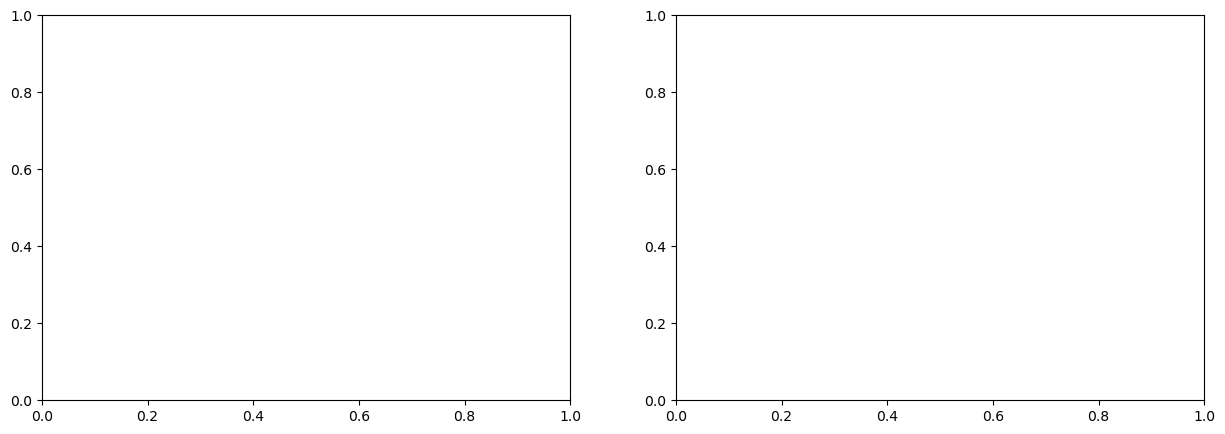

In [7]:
fitdf2=fitdf.dropna().reset_index()
for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    ddf = pd.DataFrame()
    for s in np.arange(win,20):
        ttf = fitdf.loc[fitdf["session"].isin(["sess"+str(s+1)]),:].drop(columns=["session"]).dropna()
        mod = sm.OLS(ttf[dv+"_lag0"], ttf.loc[:,~ttf.columns.str.contains("_lag0")])
        res = mod.fit()

        cdf = res.conf_int(alpha=0.05)
        cdf.columns = ["CI5", "CI95"]
        cdf["beta"] = res.params
        cdf["dv"] = dv 
        cdf["session"] = "sess"+str(s+1)

        ddf = pd.concat([ddf, cdf])

    eq = mm.generate_equation(dv+"_lag0",  list(fitdf.columns[~fitdf.columns.str.contains("_lag0")]), [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit()
    #print(res.summary())
    
  
    plotoverall = 1
    if plotoverall == 1: 
        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["iv"] = edf.index
        

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        for ll in [0, 1]:
            tedf = edf.loc[edf.index.str.contains("lag"+str(ll)),:]
            axs[ll] = sns.pointplot(x="iv", y= "beta",
                            data=tedf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                            markers="d", scale=.75, ci=None, ax=axs[ll])                
            axs[ll].vlines(np.arange(0,tedf.shape[0],1), tedf["CI5"], tedf["CI95"], colors='black')
            #axs.vlines(np.arange(3,6,1), bounds.iloc[3:6,1], bounds.iloc[3:6,2], colors='black')
            axs[ll].axhline(0, alpha=0.2, color='black')
            axs[ll].set_title(dv+" (lag"+str(ll)+")")
            axs[ll].set_ylabel("beta (ci95)")
            axs[ll].set_xlabel("")
            axs[ll].set_xticklabels(tedf["iv"], rotation = -30, ha='left')


    
    plotbysession = 0
    if plotbysession == 1:
        for v in ["AvoidBeh", "InforSeek", "DangerState", "Deaths"]: 
            if v != dv: 
                fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
                for ll in [0,1]:
                    qdf = ddf.loc[ddf.index.isin([v+"_lag"+str(ll)]),:]
                    
                    
                    axs[ll] = sns.pointplot(x="session", y= "beta",
                                    data=qdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                                    markers="d", scale=.75, ci=None, ax=axs[ll])                
                    axs[ll].vlines(np.arange(0,18,1), qdf["CI5"], qdf["CI95"], colors='black')
                    #axs.vlines(np.arange(3,6,1), bounds.iloc[3:6,1], bounds.iloc[3:6,2], colors='black')
                    axs[ll].axhline(0, alpha=0.2, color='black')
                    axs[ll].set_title(dv+" ~ "+v + "(lag"+str(ll)+")")
                    axs[ll].set_ylabel("beta (ci95)")
                    axs[ll].set_xlabel("")
                    #axs[ll].set_ylim([-0.1, 0.1])
                    #axs[ll].set_xlim([-0.5, 7.5])
                    #label = df1.groupby(by=["var", "iv", "dv", "label"])["sample"].mean().loc[[x.get_text() for x in axs[0].get_xticklabels()],:].reset_index()["label"]
                    #axs[ll].set_xticklabels(label, rotation = -30, ha='left')
        


### With indiv. diff. convariates


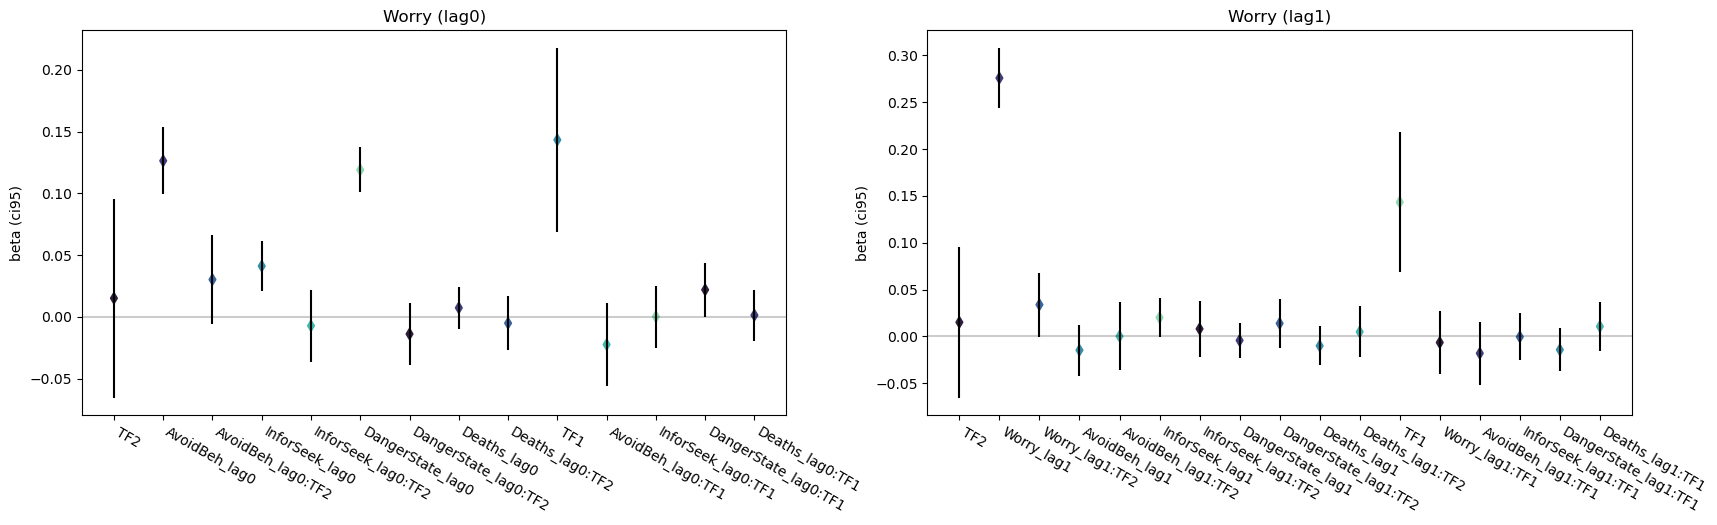

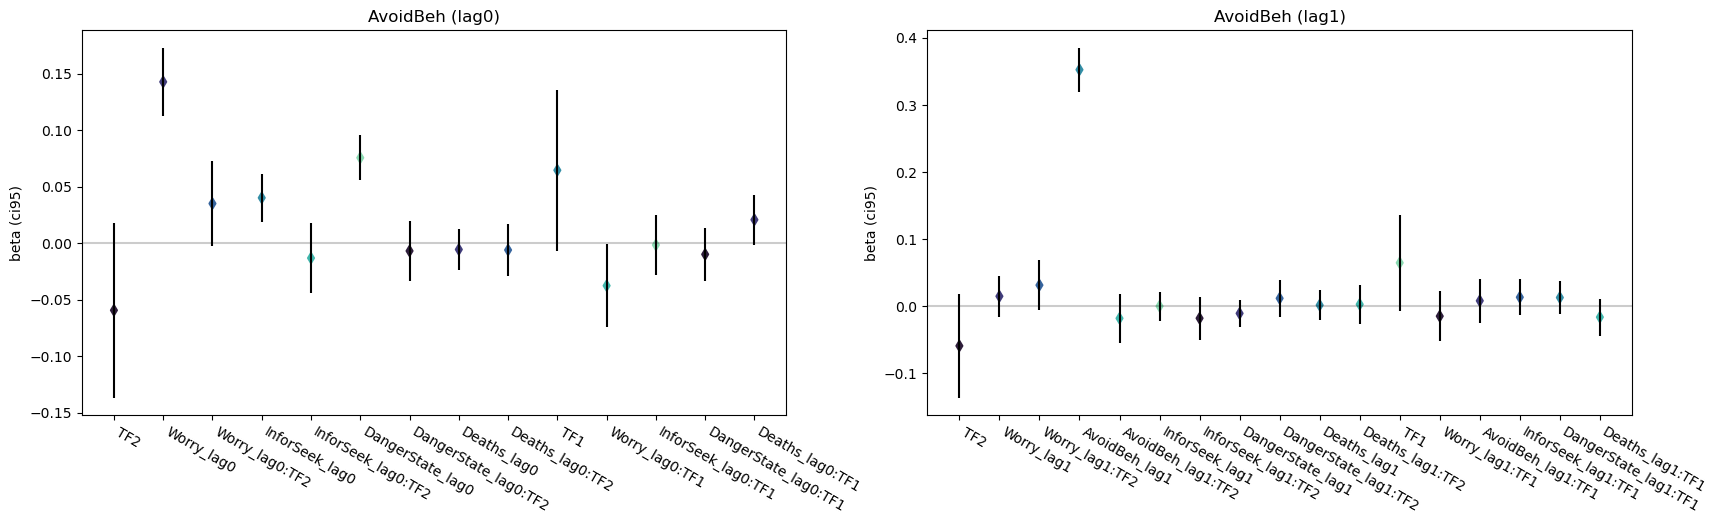

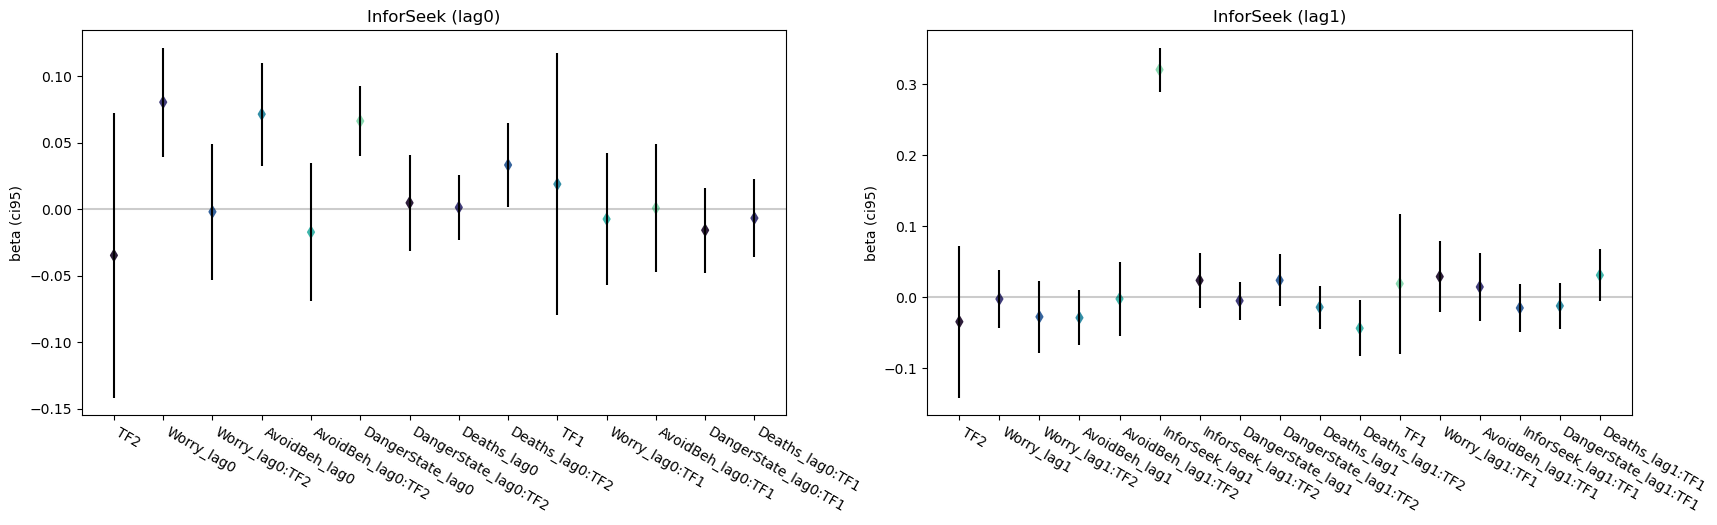

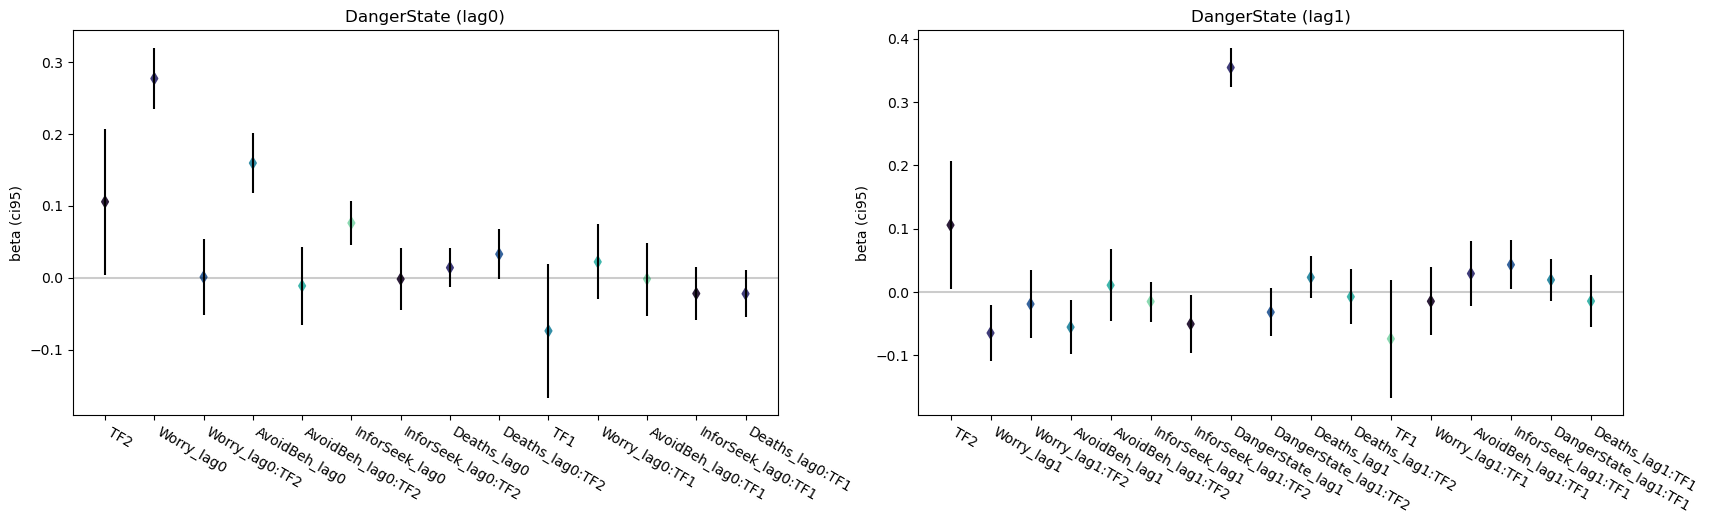

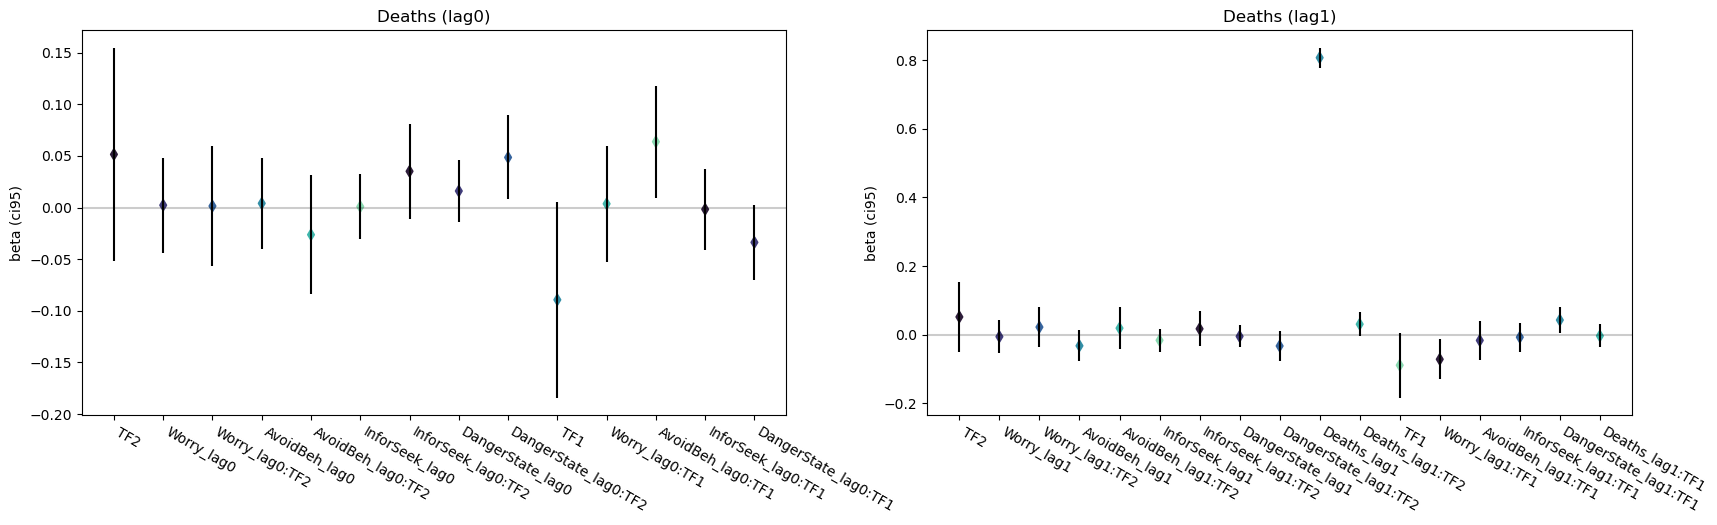

In [ ]:
# add individual difference columns
fitdf2=fitdf.join(df_id).dropna().reset_index()

for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    ddf = pd.DataFrame()
    for s in np.arange(win,20):
        ttf = fitdf2.loc[fitdf2["session"].isin(["sess"+str(s+1)]),:].drop(columns=["session", "PROLIFICID"]).dropna() 
        eq = mm.generate_equation(dv+"_lag0",  list(ttf.columns[~ttf.columns.isin([dv+"_lag0"])]), [""], "reducedrank") 
        mod = smf.ols(eq, ttf)
        res = mod.fit()

        cdf = res.conf_int(alpha=0.05)
        cdf.columns = ["CI5", "CI95"]
        cdf["beta"] = res.params
        cdf["dv"] = dv 
        cdf["session"] = "sess"+str(s+1)

        ddf = pd.concat([ddf, cdf])

    eef = pd.DataFrame()

    raw_vars = list(fitdf2.columns[~fitdf2.columns.isin([dv+"_lag0", "PROLIFICID", "TF1", "TF2", "TF3"])])
    feff = [x+"*TF2" for x in raw_vars ] + [x+"*TF1" for x in raw_vars ] 
    eq = mm.generate_equation(dv+"_lag0", feff, [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit()

    edf = res.conf_int(alpha=0.05)
    edf.columns = ["CI5", "CI95"]
    edf["beta"] = res.params
    edf["dv"] = dv 
    edf["iv"] = edf.index
    
#print(res.summary())


    plotoverall = 1
    if plotoverall == 1: 
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        for ll in [0, 1]:
            tedf = edf.loc[ ( edf.index.str.contains("lag"+str(ll)) | edf.index.isin(["TF1", "TF2", "TF3"])) & ~(edf.index.str.contains("session")) & ~(edf.index.isin(["Intercept", "Group Var"])),:]
            axs[ll] = sns.pointplot(x="iv", y= "beta",
                            data=tedf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                            markers="d", scale=.75, ci=None, ax=axs[ll])                
            axs[ll].vlines(np.arange(0,tedf.shape[0],1), tedf["CI5"], tedf["CI95"], colors='black')
            #axs.vlines(np.arange(3,6,1), bounds.iloc[3:6,1], bounds.iloc[3:6,2], colors='black')
            axs[ll].axhline(0, alpha=0.2, color='black')
            axs[ll].set_title(dv +" (lag"+str(ll)+")")
            axs[ll].set_ylabel("beta (ci95)")
            axs[ll].set_xlabel("")
            axs[ll].set_xticklabels(tedf["iv"], rotation = -30, ha='left')

    plotbysession = 0
    if plotbysession == 1:
        for v in ["AvoidBeh", "InforSeek", "DangerState", "Deaths"]: 
            if v != dv: 
                fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
                for ll in [0,1]:
                    qdf = ddf.loc[ddf.index.isin([v+"_lag"+str(ll)]),:]
                    
                    
                    axs[ll] = sns.pointplot(x="session", y= "beta",
                                    data=qdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                                    markers="d", scale=.75, ci=None, ax=axs[ll])                
                    axs[ll].vlines(np.arange(0,18,1), qdf["CI5"], qdf["CI95"], colors='black')
                    #axs.vlines(np.arange(3,6,1), bounds.iloc[3:6,1], bounds.iloc[3:6,2], colors='black')
                    axs[ll].axhline(0, alpha=0.2, color='black')
                    axs[ll].set_title(dv+" ~ "+v + "(lag"+str(ll)+")")
                    axs[ll].set_ylabel("beta (ci95)")
                    axs[ll].set_xlabel("")
                    #axs[ll].set_ylim([-0.1, 0.1])
                    #axs[ll].set_xlim([-0.5, 7.5])
                    #label = df1.groupby(by=["var", "iv", "dv", "label"])["sample"].mean().loc[[x.get_text() for x in axs[0].get_xticklabels()],:].reset_index()["label"]
                    axs[ll].set_xticklabels(label, rotation = -30, ha='left')

In [ ]:
list(fitdf.columns[~fitdf.columns.isin([dv+"_lag0"])] )

['Worry_lag2',
 'Worry_lag1',
 'Worry_lag0',
 'session',
 'AvoidBeh_lag2',
 'AvoidBeh_lag1',
 'AvoidBeh_lag0',
 'InforSeek_lag2',
 'InforSeek_lag1',
 'InforSeek_lag0',
 'DangerState_lag2',
 'DangerState_lag1',
 'DangerState_lag0',
 'Deaths_lag2',
 'Deaths_lag1']

In [ ]:
eq = mm.generate_equation(dv+"_lag0",  list(fitdf.columns[~fitdf.columns.isin([dv+"_lag0"])]), [""], "reducedrank") 
#eq = mm.generate_equation("x",  ["d","dd"], ["1|id"], "reducedrank") 
eq

'Deaths_lag0 ~ Worry_lag2 + Worry_lag1 + Worry_lag0 + session + AvoidBeh_lag2 + AvoidBeh_lag1 + AvoidBeh_lag0 + InforSeek_lag2 + InforSeek_lag1 + InforSeek_lag0 + DangerState_lag2 + DangerState_lag1 + DangerState_lag0 + Deaths_lag2 + Deaths_lag1'

In [ ]:
cdf = res.conf_int(alpha=0.05)
cdf.columns = ["CI5", "CI95"]
cdf["beta"] = res.params